# Evaluate localized damped wave solution 

This script evaluates a localized approximation to $u^n \in V_h$ that solves

$$(u^n, z) + \tau a(u^n, z) + \tau^2 b(u^n, z) = \tau^2 (f,z) + \tau a(u^{n-1}, z) + 2(u^{n-1}, z) - (u^{n-2}, z), \quad \forall z\in V_h,$$

by evaluating its (localized) decomposed parts $v^n_k \in V^{\text{ms}'}_{H,k}$ and $w^n_k \in V^f_{h,k}$. The script plots the error for different choices of $k_0$ and $k_1$, and in this example the parameters are varied such that $k_0=4,5,6$ and $k_1 = k_0 - 1$.

Plot the error $\|u^n_k - v^n_k - w^n_k\|_{L^2}$.

In [1]:
import numpy as np
import scipy.sparse as sparse
import matplotlib.pyplot as plt
from gridlod import util, fem, coef, interp, linalg
from gridlod.world import World
import lod_wave

'''
Settings
'''

# fine mesh parameters
fine = 256
NFine = np.array([fine])
NpFine = np.prod(NFine+1)
boundaryConditions = np.array([[0, 0]])
world = World(np.array([256]), NFine/np.array([256]), boundaryConditions)
NWorldFine = world.NWorldCoarse * world.NCoarseElement

# fine grid elements and nodes
xt = util.tCoordinates(NFine).flatten()
xp = util.pCoordinates(NFine).flatten()

# time step parameters
tau = 0.01
numTimeSteps = 100

# ms coefficients
epsA = 2**(-4)
epsB = 2**(-6)
aFine = (2 - np.sin(2 * np.pi * xt / epsA)) ** (-1)
bFine = (2 - np.cos(2 * np.pi * xt / epsB)) ** (-1)

# localization and mesh width parameters
kList = [4, 5, 6]
NList = [2, 4, 8, 16, 32, 64]

error = []

for k in kList:

    errork = []
    for N in NList:

        # coarse mesh parameters
        NWorldCoarse = np.array([N])
        NCoarseElement = NFine / NWorldCoarse
        world = World(NWorldCoarse, NCoarseElement, boundaryConditions)

        # grid nodes
        xpCoarse = util.pCoordinates(NWorldCoarse).flatten()
        NpCoarse = np.prod(NWorldCoarse + 1)

        '''
        Compute multiscale basis
        '''

        # patch generator and coefficients
        IPatchGenerator = lambda i, N: interp.L2ProjectionPatchMatrix(i, N, NWorldCoarse,
                                                    NCoarseElement, boundaryConditions)
        b_coef = coef.coefficientFine(NWorldCoarse, NCoarseElement, bFine)
        a_coef = coef.coefficientFine(NWorldCoarse, NCoarseElement, aFine / tau)

        # compute basis correctors
        lod = lod_wave.LodWave(b_coef, world, k, IPatchGenerator, a_coef)
        lod.compute_basis_correctors()

        # compute ms basis
        basis = fem.assembleProlongationMatrix(NWorldCoarse, NCoarseElement)
        basis_correctors = lod.assembleBasisCorrectors()
        ms_basis = basis - basis_correctors


        '''
        Compute finescale system
        
        fs_solutions[i] = {w^i_x}_x
        '''

        prev_fs_sol = None
        fs_solutions = []
        for i in xrange(numTimeSteps):
            # solve system
            lod = lod_wave.LodWave(b_coef, world, k-1, IPatchGenerator, a_coef, 
                                   prev_fs_sol, ms_basis)
            lod.solve_fs_system(localized=True)

            # store sparse solution
            prev_fs_sol = sparse.csc_matrix(np.array(np.column_stack(lod.fs_list)))
            fs_solutions.append(prev_fs_sol)

        '''
        Compute v^n and w^n
        '''

        # initial value
        Uo = xpCoarse * (1 - xpCoarse)

        # coarse v^(-1) and v^0
        V = [Uo]
        V.append(Uo)

        # fine v^(-1) and v^0
        VFine = [ms_basis * Uo]
        VFine.append(ms_basis * Uo)

        # reference solution
        UFine = [ms_basis * Uo]
        UFine.append(ms_basis * Uo)

        # initial value w^0
        Wo = np.zeros(NpFine)
        WFine = [Wo]

        # compute ms matrices
        S = fem.assemblePatchMatrix(NWorldFine, world.ALocFine, aFine)
        K = fem.assemblePatchMatrix(NWorldFine, world.ALocFine, bFine)
        M = fem.assemblePatchMatrix(NWorldFine, world.MLocFine)

        SmsFull = ms_basis.T * S * ms_basis
        KmsFull = ms_basis.T * K * ms_basis
        MmsFull = ms_basis.T * M * ms_basis

        free  = util.interiorpIndexMap(NWorldCoarse)

        SmsFree = SmsFull[free][:,free]
        KmsFree = KmsFull[free][:,free]
        MmsFree = MmsFull[free][:,free]

        boundaryMap = boundaryConditions == 0
        fixedFine = util.boundarypIndexMap(NWorldFine, boundaryMap)
        freeFine = np.setdiff1d(np.arange(NpFine), fixedFine)

        # load vector
        f = np.ones(NpFine)
        LFull = M * f
        LmsFull = ms_basis.T * LFull
        LmsFree = LmsFull[free]

        RmsFreeList = []
        for i in xrange(numTimeSteps):

            n = i + 1

            # linear system
            A = (1./(tau**2)) * MmsFree + (1./tau) * SmsFree + KmsFree
            b = LmsFree + (1./tau) * SmsFree * V[n][free] + (2./(tau**2)) * MmsFree * V[n][free] - (1./(tau**2)) * MmsFree * V[n-1][free]

            # store ms matrix R^{ms',h}_{H,i,k}
            RmsFull = ms_basis.T * S * fs_solutions[i]
            RmsFree = RmsFull[free][:, free]
            RmsFreeList.append(RmsFree)

            # add sum to linear system
            if i is not 0:
                for j in range(i):
                    b += (1. / tau) * RmsFreeList[j] * V[n-1-j][free]


            # solve system
            VFree = linalg.linSolve(A, b)
            VFull = np.zeros(NpCoarse)
            VFull[free] = VFree

            # append solution for current time step
            V.append(VFull)
            VFine.append(ms_basis * VFull)

            # evaluate w^n
            w = 0
            if i is not 0:
                for j in range(0, i + 1):
                    w += fs_solutions[j] * V[n-j]
            WFine.append(w)

        '''
        Compute reference solution
        '''

        # fine free indices
        boundaryMap = boundaryConditions == 0
        fixedFine = util.boundarypIndexMap(NWorldFine, boundaryMap)
        freeFine = np.setdiff1d(np.arange(NpFine), fixedFine)

        SFree = S[freeFine][:, freeFine]
        KFree = K[freeFine][:, freeFine]
        MFree = M[freeFine][:, freeFine]

        f = np.ones(NpFine)
        LFineFull = M * f
        LFineFree = LFineFull[freeFine]

        for i in range(numTimeSteps):
            n = i + 1

            # reference system
            A = (1./(tau**2)) * MFree + (1./tau) * SFree + KFree
            b = LFineFree + (1./tau) * SFree * UFine[n][freeFine] + (2./(tau**2)) * MFree * UFine[n][freeFine] -\
                (1./(tau**2)) * MFree * UFine[n-1][freeFine]

            # solve system
            UFineFree = linalg.linSolve(A, b)
            UFineFull = np.zeros(NpFine)
            UFineFull[freeFine] = UFineFree

            # append solution
            UFine.append(UFineFull)

        # evaluate L^2-error for time step N
        errork.append(np.sqrt(np.dot((UFine[-1] - VFine[-1] - WFine[-1]), (UFine[-1] - VFine[-1] - WFine[-1]))))

    error.append(errork)

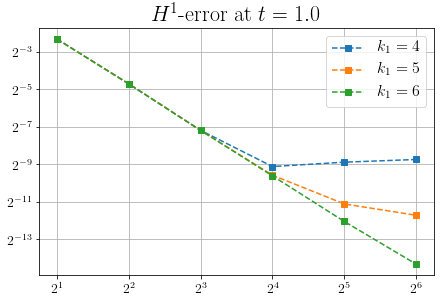

In [2]:
# plot errors
plt.figure('Error comparison')
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.subplots_adjust(left=0.075, bottom=0.06, right=0.99, top=0.92, wspace=0.1, hspace=0.2)
plt.tick_params(labelsize=14)
for i in range(len(kList)):
    plt.loglog(NList, error[i], '--s', basex=2, basey=2, label='$k_1=%d$' %kList[i])
plt.grid(True, which="both")
plt.title(r'$H^1$-error at $t=%.1f$' % (numTimeSteps * tau), fontsize=22)
plt.legend(fontsize=16)

plt.show()